In [97]:
%pylab inline
import json
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import sklearn
import pandas as pd
from typing import Tuple
from typing import List
from collections import defaultdict
from itertools import combinations
dataset = pd.read_csv('data/synchronized-eeg.csv',
                      parse_dates=['indra_time'],
                      index_col='indra_time')
# convert to arrays from strings
dataset.raw_values = dataset.raw_values.map(json.loads)

Populating the interactive namespace from numpy and matplotlib


C:\Users\Xuancheng Fan\AppData\Local\Programs\Python\Python35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['math', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 1. EEG

Neurons produce electrical activity in the brain.

If we zoom out far enough (and, for our purposes, we must), these neuronal firings appear most clearly as patterns of constructive or destructive interference. They are typically low-frequency waves, 0.5Hz-70Hz.

But, don't take my word for it. Let's open up a signal from our corpus.

Here's 512 readings, or one second, of the 30,000 seconds in our dataset. Let's take the 100th reading in our dataset:

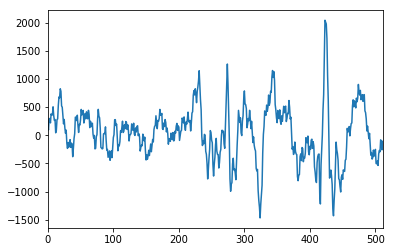

In [2]:
pd.Series(dataset.raw_values[100].values).plot()

This is *time-domain* data. It represents voltages over time.

We can turn this into *frequency-domain* data using an [FFT](https://www.youtube.com/watch?v=iWZNTM139xQ). (You don't need to understand how this works right now). We'll produce what's called a *power spectrum*.


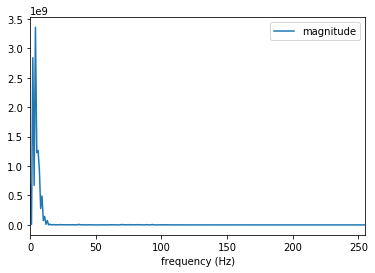

In [3]:
def to_power_spectrum (
    raw_readings: np.array,
    sampling_rate: int = 512,
) -> pd.Series:
    '''
    Take raw voltages,
    transform into frequency domain,
    return a power spectrum.
    '''
    # FFT the raw readings
    fftd = np.fft.fft(raw_readings)
    # take absolute value
    # producing a symmetrical power spectrum
    ps = np.abs(fftd)**2
    # since the power spectrum is symmetrical, 
    # take half
    half_len = len(ps)//2
    ps = ps[:half_len]
#     # we'll calculate the frequencies
    window_size = len(raw_readings)
    freqs = numpy.fft.fftfreq(window_size, d=1/sampling_rate)
#     # splitting that in half to match
    freqs = freqs[:half_len]
    power_spectrum = pd.DataFrame({
        'frequency (Hz)': freqs,
        'magnitude': ps,
    })
    return power_spectrum

ps = to_power_spectrum(dataset.raw_values[1000])
ps.plot(x='frequency (Hz)')

Now, we can see some low-frequency data, toward the left side of the graph

Let's do a "band-pass" between 0.5Hz and 20Hz, effectively "zooming in" or "cropping" to these frequencies.

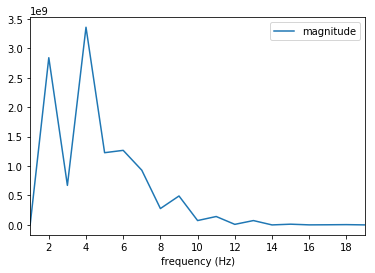

In [4]:
def bandpass (
    power_spec: pd.Series,
    low_cutoff: float,
    high_cutoff: float,
) -> pd.Series:
    return power_spec[(power_spec['frequency (Hz)'] > low_cutoff) & 
                      (power_spec['frequency (Hz)'] < high_cutoff)]

bandpass(ps, 0.5, 20).plot(x='frequency (Hz)')

Now, here's the problem: There's a bunch of other crap in the signal, too!

For example, along with the EEG signal we just saw, there's also a bunch of EMG (electromyographic) data, which is produced by the muscles in your face, or from moving your eyes!

Most of this signal will be in the *50Hz to 150Hz* range. Eyeblinks will cause big spikes in this frequency band.

### TODO
Bandpass to the EMG frequency bands, and plot them. If you want, see if you can find any readings with big spikes in this band!

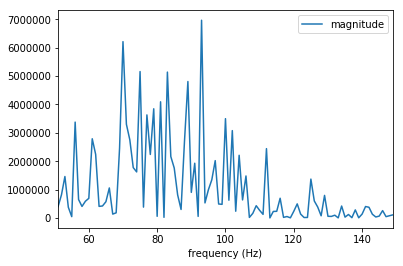

In [5]:
# your code here
bandpass(ps, 50, 150).plot(x='frequency (Hz)')

We might also see ECG (electrocardiographic) signals, from the heart.

We'll even see background radiation from the electrical system! Here in North America, we'll see a 60Hz spike no matter what we do.

# 2. Classification

We can go crazy trying to filter all of these artifacts (and many have). 

However, we are at Berkeley, so we will take a lazy (computational) view.

We will shift our perspective in two ways, and in the end, we will not feel obligated to filter artifacts:

1. *The electromagnet is a general-purpose **biosensor***. We are sensing a multitude of human activity, including, but not limited to, EEG.

2. *Our machine learning will handle the artifacts*. If some artifacts really are artifacts (i.e., they are not informative with respect to our problem domain), then our ML will simply learn to ignore them.

`<OPTIONAL NOTE>`

These two "perspective shifts" are tightly intertwined. If you are up for it, try using the second as a lens for viewing the first. Our assumptions about EEG melt away, and we are left only with a classification problem and a signal (and the assumptions [built into those infrastructures](https://mitpress.mit.edu/books/raw-data-oxymoron) ;) ). 

We do not need to make specific commitments about what mechanisms produce the effects we are interested in. Thus, we avoid all hard epistemolgical questions (and complaints)! We are also free to discover signals that might come from unexpected places.  

If this is over your head, just remember this: If we're trying to classify interest (say), perhaps an unconscious eyebrow raise is our key signal. It would be a shame if we filtered it out, in our myopic quest for a "clean" EEG signal!

`</OPTIONAL NOTE>`

Fine, so what kind of classifier will just handle the artifacts for us?
I know, I know, you're probably thinking of neural networks. [That's an option](https://arxiv.org/pdf/1611.08024.pdf).

But, for now, we will use something much simpler, and much easier to run on your laptop: [XGBoost](https://github.com/dmlc/xgboost). You can [read up](https://xgboost.readthedocs.io/en/latest/model.html) on XGBoost on your own time, but like the FFT, you don't need to know how it works right now.

In fact, you don't even need to know what machine learning is. I will just show you an example of how to use XGBoost, and we can go from there.

First, let's make a plain, *untrained* classifier.

In [6]:
def fresh_clf () -> XGBClassifier:
    return XGBClassifier(
        # Don't worry about those parameters for now,
        # though feel free to look them up if you're interested.
        objective= 'binary:logistic',
        seed=27)

clf = fresh_clf()


Right now, this classifier is fresh to the world. It has seen no evil, heard no evil...

The "learning" part happens when our  classifier is *trained*, or *fit*, using examples. These examples have *labels*, and *features*. Our classifier will study the relationship between features and labels, so that in the future, it can map features to labels (more on this in a second).

Our **features** here are pretty clear: electromagnetic signals, our power spectra.

Our **labels** can really be anything, but for now, let's pick stuff that's easy from the existing dataset: People who are doing math, and people who are doing nothing. 

In [7]:
# All the readings during the "relax" task
relax = dataset[(dataset.label == 'relax') &
                (dataset.id == 1) ]
# All the readings taken during "math" tasks
# (Math tasks were labeled math1...math12 -
#  `math\d` is a "regular expression," or RegEx)
math = dataset[(dataset.label.str.match('math\d')) &
               (dataset.id == 1) ]

len(relax), len(math)

(30, 30)

Now, we'll go about preparing our data for the classifier. 

Since our features are the power spectra, we should assemble a big collection of power spectra - and nothing else.

In [8]:
def to_features (
    df: pd.DataFrame
) -> np.array:
    power_specs = df.raw_values.apply(to_power_spectrum)
    return np.array([row.magnitude.values for row in power_specs])

Now we can make a big list of all features, with their labels removed.

In [9]:
relax_features = to_features(relax)
math_features = to_features(math)
features = np.concatenate([relax_features, math_features])
    
assert np.all( [ len(feat) == 256 for feat in features ] )

However, for each of these features, we will need corresponding labels.

Since our machine has no semantic knowledge of what these labels "mean," we will simply refer to them as 0 and 1, respectively.

In [10]:
labels = np.array([ 0 for feature in relax_features  ] \
                + [ 1 for feature in math_features ])

# list of labels should be the same 
# as the number of features
assert len(labels) == len(features)
# first label in the list should be 0
assert labels[0] == 0
# last label in the list should be 1
assert labels[-1] == 1

labels[:5], labels[-5:]

(array([0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1]))

What we are left with are two matrices (numpy arrays): one of the features, and one of the labels. The labels matrix is one-dimensional. 

The features matrix can be have another dimension of any length. However, along its first dimension, it must be the same shape as the labels, so that the two align (every feature has a label).

So, here, our labels are `n x 1`, and our features are `256 x n`. (Our sampling rate is 512, producing power spectra of size 256.)


In [11]:
assert features.shape[0] == labels.shape[0]

features.shape, labels.shape

((60, 256), (60,))

By convention, we refer to the features matrix as `X` and the labels matrix as `y`. 

(I know, I know. Mathematicians have no idea how to name a variable. But, the variable names `X` and `y` are so common in literature and documentation, I feel you should be familiar with them. And thus I perpetuate the problem...)

In [12]:
X = features
y = labels

Now, we can finally train our classifier!

In [13]:
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1)

Great, we trained it! So, how does it do?

Aha, but if we've used all of our data to trian the classifier, what can we use to *test* the classifier?

We could test the classifier on the exact same stuff we trained it on, but *WE SHOULD NEVER DO THIS!!! NEVER TEST ON THE TRAIN SET!!* 

Why? The answer has to do with a concept called *overfitting*. 

> A model *overfits* to its data when it explains the data it was trained on *so exactly* that it no longer generalizes to new, unseen data. 

For example, a model may memorize the data, including noise in the data, to produce perfect accuracy. Effectively, it will memorize the data! How useful will this memorization be in classifying data it's never seen before? Not very!

To get around this, we *split* the data into train and test sets.

In [14]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, 
    # We will withold 33% of the data for the test split.
    test_size=0.33, 
    # We'll fix this parameter,
    # so that we'll always produce the same
    # "random" split on each run.* 
    random_state=42)

# (Remember, there's nothing "random" on a computer,
#  but, we do have *pseudo-*random number generators
#  (PRNGs) which are almost as good. If we fix the seed,
#  they will always generate the same sequence of numbers.
#  However, to someone who doesn't know the seeds, the
#  numbers look like white noise. Magic! You ever wonder
#  how garage door openers work? Research more
#  on your own time.)

Now we can train a *fresh* classifier on the train set,

In [15]:
clf = fresh_clf()
#clf.fit(X_train, y_train,  eval_metric =['auc'], early_stopping_rounds= 30, eval_set =[[X_test, y_test]])
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1)

and test on the test set!

In [16]:
clf.score(X_test, y_test)

0.90000000000000002

But XGBoost is even smarter than that. 

Oh yes, XGBoost is very smart. It can take some data, randomly split it into train and test sets, then see how well it does on the test set. It will use these results to tweak its parameters. Then, it can repeat this process a number of times, until it starts doing very well!


In [17]:
def xgb_cross_validate (
    X: np.array,
    y: np.array,
    nfold: int=7
) -> Tuple[XGBClassifier, pd.DataFrame]:
    # eval_metrics:
    # http://xgboost.readthedocs.io/en/latest//parameter.html
    metrics = ['error@0.1', 'auc']
#     metrics = [ 'auc' ]
    # we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
    # the intent here to to minimize FAR at the expense of FRR
    #print(stopping_rounds)
    alg = fresh_clf()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds = 100
                      )
    #print(len(cvresults))
    alg.set_params(n_estimators=cvresults.shape[0])
    #print(alg.get_xgb_params())
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

Now we'll now split the data into a *train* set (for which XGBoost will manage the train/test splitting), and a *validation* set, which we will use to see the results of XGBoost's efforts.

In [18]:
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)

This `cvres` value is actually a DataFrame detailing each "tweaking" step XGBoost did in training the parameters. We can inspect the last few rows to see what it did right before it delievered the classifier to us.

(If you notice in the `xgb_cross_validate` method above, we specified an `early_stopping_rounds`. We keep tweaking parametmers until the results are pretty high, or until we have tried for 100 rounds - whichever comes first).

In [19]:
print(clf)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=1)


In [20]:
cvres.tail()

,test-auc-mean,test-auc-std,test-error@0.1-mean,test-error@0.1-std,train-auc-mean,train-auc-std,train-error@0.1-mean,train-error@0.1-std
95,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396
96,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396
97,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396
98,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396
99,0.934524,0.11755,0.328571,0.201131,1.0,0.0,0.037455,0.020396


In [21]:
clf.score(X_validate, y_validate)

0.90000000000000002

## TODO

** For how many rounds did XGBoost tweak our classifier, above, before stopping? **

100  

For this issue, I tried to change the early_stopping_rounds to other values, e.g. 120, 200, 1000. But the number of iteration is still 100. It means after 100 iterations, the model has reached the result threshold at first, not the the limitation of the number of rounds

** What is the estimated accuracy of our classifier at distinguishing between "math" and "relax" tasks, across all subjects? **

According to the results above, for user1(id ==1), the accuracy is 0.934524 for training dataset, 0.9 for test dataset 

According to the codes below to train the model on all subjects' result, the accuary is 0.617365 for training datest, 0.624595 for test dataset

In [23]:
# All the readings during the "relax" task and All the readings taken during "math" tasks
relax = dataset[(dataset.label == 'relax')]
math = dataset[(dataset.label.str.match('math\d')) ]

len(relax), len(math)

(934, 936)

In [24]:
relax_features = to_features(relax)
math_features = to_features(math)
features = np.concatenate([relax_features, math_features])
assert len(features) == (934+936)
assert np.all( [ len(feat) == 256 for feat in features ] )


In [25]:
labels = np.array([ 0 for feature in relax_features  ] \
                + [ 1 for feature in math_features ])

# list of labels should be the same 
# as the number of features
assert len(labels) == len(features)
# first label in the list should be 0
assert labels[0] == 0
# last label in the list should be 1
assert labels[-1] == 1

labels[:5], labels[-5:]

(array([0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1]))

In [26]:
X = features
y = labels

In [28]:
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)

In [29]:
cvres

,test-auc-mean,test-auc-std,test-error@0.1-mean,test-error@0.1-std,train-auc-mean,train-auc-std,train-error@0.1-mean,train-error@0.1-std
0,0.531495,0.023444,0.503228,0.037529,0.674066,0.017802,0.503196,0.006254
1,0.542732,0.021142,0.503228,0.037529,0.727519,0.013491,0.503196,0.006254
2,0.568709,0.036986,0.503228,0.037529,0.765671,0.017915,0.503196,0.006254
3,0.566698,0.041260,0.503228,0.037529,0.791699,0.015758,0.503196,0.006254
4,0.564925,0.038102,0.503228,0.037529,0.802514,0.011399,0.503196,0.006254
5,0.579043,0.025694,0.503228,0.037529,0.821173,0.010212,0.503196,0.006254
6,0.578182,0.028854,0.503228,0.037529,0.833347,0.012704,0.503196,0.006254
7,0.589621,0.032539,0.503228,0.037529,0.840642,0.010516,0.503196,0.006254
8,0.590153,0.021526,0.503228,0.037529,0.851611,0.007050,0.503196,0.006254
9,0.588511,0.018852,0.503228,0.037529,0.863190,0.007916,0.503196,0.006254


In [30]:
clf.score(X_validate, y_validate)

0.62459546925566345

## TODO

In this notebook, why did our classifier do as well as it did?

In answering this question, do research, and make educated guesses based on what you learn. Optionally make arguments based on any any evidence you can collect. 

There are no right or wrong answers here. Nor is there only one answer - there are potentially a number of possible explanations! 

Some questions I always ask myself whenever I come up with explanations:

- Could I test this theory? How?
- Are there any *other* explanations? Can I test those?
- Why might the current results be misleading?

I think the classifier's success is based on the concept that each kind of activity would have different frequencies. 
According to http://nhahealth.com/brainwaves-the-language/ and https://www.binauralbeatsfreak.com/brainwave-entrainment/alpha-brain-waves-everything-you-need-to-know, below is a summary of the different frequency and their related works:  
DELTA (0.1 to 3.5 Hz): Associated tasks & behaviors: lethargic, not moving, not attentive  
THETA (4-8 Hz): Associated tasks & behaviors: creative, intuitive; but may also be distracted, unfocused  
ALPHA (8-12 Hz): Associated tasks & behaviors: meditation, no action, visualization   
BETA (12-30HZ): Associated tasks & behaviors: mental activity
GAMMA (above 30hz Hz): Associated tasks & behaviors: high-level information processing, “binding”  

According to our dataset, we have 6 main activities: colorround, math, music, relax, thinkofItems, video.
So to illustrate the concept, it is reasonable to check the frequency chart of each activity to see if they have their unique patterns. I used the median value of each feature (256 features) to represent an average frequency chart of each activity.  

In the frequency charts (bandpass 3.5 Hz - 50 Hz):    

About relax, we can see high magnitudes in Theta area. But according to the articles, "relax"'s magnitude should be in Alpha area. I think the reason is that, during the test, participants are not fully relaxed. When asked to relax, they were still thinking but unfocused. But true relax requires calm and focus.  

About math and music, they look quite similar while they are both mental activities. However, maths has a high magnitude around 20 Hz. It is the HIGH BETA area and it matches the function of HIGH BETA whose associated task is math.

About video, although it is also a mental activity, the biggest difference is that it has a high magnitude in the ALPHA area which is responsible for the visualization. 

About color, obviously, it has a high magnitude in GAMMA which matches the feature that is high-level information processing, “binding”.

About think, it is clearly a kind of meditation without action. So it has only a high magnitude in ALPHA area. 

In all, according to the frequency chart, we can see the obvious difference between each activity. It also explains why we can get high accuracy of subject 1's "relax" and "math"

However, this result might be misleading. In Q2, while we need to test the accuracy on all subjects, we can see the result drops a lot. Obviously, for some subjects, the difference between "relax" and "math" is distinct while for others, it is blurry. Or it might result from that it is difficult for the participants to put the same effort or focus on the test. 

At last, I tried to see which pair of activity is the easiest one to differentiate and which one is the most stable. I run the code on each pair of activity of each subject and calculate the mean average and stand deviation error(STD).

As a result, the pair of "think" and "color" has the highest accuracy, 79% (std: 0.10). The pair of "color" and "math" has the lowest STD which is 0.07 (accuracy: 76%)

In conclusion, the brain waves could tell us a lot about the activity. However, the difference between the activities is unstable for different subjects. For some subjects, the gap would be great in activity 1 and 2 while for other, the gap would be small.     


#### Frequency Charts

In [32]:
set(dataset.label.values)

{'blink1',
 'blink2',
 'blink3',
 'blink4',
 'blink5',
 'blinkInstruction',
 'colorInstruction1',
 'colorInstruction2',
 'colorRound1-1',
 'colorRound1-2',
 'colorRound1-3',
 'colorRound1-4',
 'colorRound1-5',
 'colorRound1-6',
 'colorRound2-1',
 'colorRound2-2',
 'colorRound2-3',
 'colorRound2-4',
 'colorRound2-5',
 'colorRound2-6',
 'colorRound3-1',
 'colorRound3-2',
 'colorRound3-3',
 'colorRound3-4',
 'colorRound3-5',
 'colorRound3-6',
 'colorRound4-1',
 'colorRound4-2',
 'colorRound4-3',
 'colorRound4-4',
 'colorRound4-5',
 'colorRound4-6',
 'colorRound5-1',
 'colorRound5-2',
 'colorRound5-3',
 'colorRound5-4',
 'colorRound5-5',
 'colorRound5-6',
 'math1',
 'math10',
 'math11',
 'math12',
 'math2',
 'math3',
 'math4',
 'math5',
 'math6',
 'math7',
 'math8',
 'math9',
 'mathInstruction',
 'music',
 'musicInstruction',
 'readyRound1',
 'readyRound2',
 'readyRound3',
 'readyRound4',
 'readyRound5',
 'relax',
 'relaxInstruction',
 'thinkOfItems-ver1',
 'thinkOfItems-ver2',
 'thinkOfIt

In [33]:
len(set(dataset.id.values))

30

In [60]:
def median_value_plot(raw_values):
    temp_dict = defaultdict(list)
    temp_list = []
    # since the raw_value is a list, recreate new lists that contains the values in the same position in the lists
    # calculate one position by one postion, and recombine to a list 
    for i in raw_values:
        for j in range(256):
            temp_dict[j].append(i[j])
    for i in range(256):
        temp_list.append(np.median(temp_dict[i]))
    ps = to_power_spectrum(temp_list)
    bandpass(ps, 3.5, 50).plot(x='frequency (Hz)')

In [61]:
def dataset_dict(dataset, id_number):
    # 0: relax, 1: math, 2: color
    # 3: music, 4: video 5: think
    dataset_dict = {}
    dataset_dict[0] = dataset[(dataset.label == 'relax') & (dataset.id == id_number) ]
    dataset_dict[1] = dataset[(dataset.label.str.match('math\d')) & (dataset.id == id_number)]
    dataset_dict[2] = dataset[(dataset.label.str.match('colorRound\d.*')) & (dataset.id == id_number)]
    dataset_dict[3] = dataset[(dataset.label == 'music') & (dataset.id == id_number)]
    dataset_dict[4] = dataset[(dataset.label.str.match('video-ver\d')) & (dataset.id == id_number)]
    dataset_dict[5] = dataset[(dataset.label.str.match('thinkOfItems-ver\d')) & (dataset.id == id_number)]
    return dataset_dict

In [62]:
dataset_dict_1 = dataset_dict(dataset, 1)

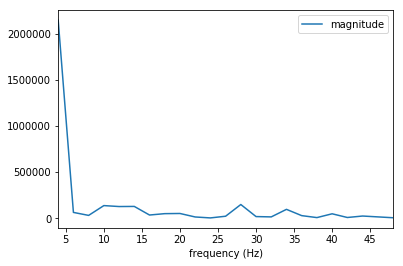

In [63]:
relax = dataset_dict_1[0]
#ps = to_power_spectrum(relax.raw_values[2])
#bandpass(ps, 0.5, 30).plot(x='frequency (Hz)')
median_value_plot(relax.raw_values)

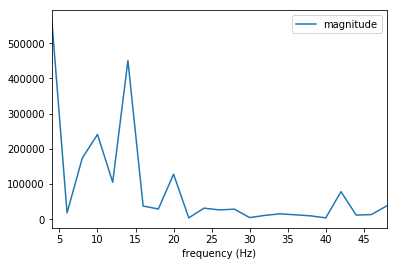

In [64]:
math = dataset_dict_1[1]
median_value_plot(math.raw_values)

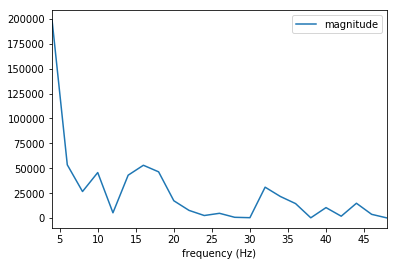

In [65]:
color = dataset_dict_1[2]
median_value_plot(color.raw_values)

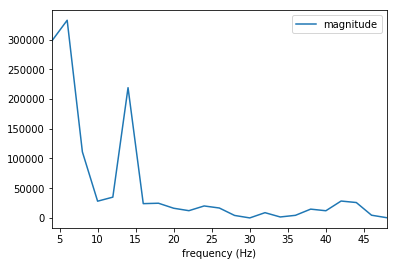

In [66]:
music =  dataset_dict_1[3]
median_value_plot(music.raw_values)

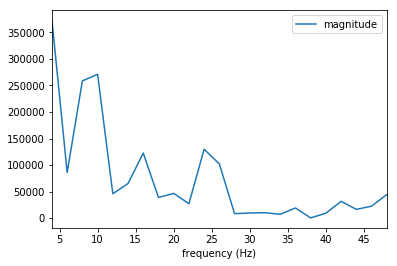

In [67]:
video =  dataset_dict_1[4]
median_value_plot(video.raw_values)

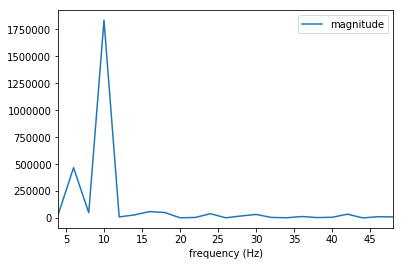

In [68]:
think = dataset_dict_1[5]
median_value_plot(think.raw_values)

#### Matrix (average result on 30 peoples)

In [46]:
summary_dict = defaultdict(list)
for id_number in range(1, 31):
    dataset_dict_user = dataset_dict(dataset, id_number)
    for i in range(0,6):
        for j in range(i+1,6):
            category1 = dataset_dict_user[i]
            category2 = dataset_dict_user[j]
            features1 = to_features(category1)
            features2 = to_features(category2)
            features = np.concatenate([features1, features2])
            labels = np.array([ 0 for feature in features1  ] \
                            + [ 1 for feature in features2 ])
            X = features
            y = labels
            X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
                                                        X, y, 
                                                        test_size=0.33, 
                                                        random_state=42)
            try:
                clf, cvres = xgb_cross_validate(X_train, y_train)
                #print(id_number, i, j, clf.score(X_validate, y_validate))
                summary_dict['{}-{}'.format(i,j)].append(clf.score(X_validate, y_validate))
            except:
                print(id_number, i, j)

15 2 3
15 2 4
15 2 5


In [47]:
result_dict = defaultdict(list)
pd_mean_list = []
pd_std_list = []
for i in range(6):
    pd_mean_list.append([0,0,0,0,0,0])
    pd_std_list.append([0,0,0,0,0,0])
for i in range(0,6):
    for j in range(0,6):
        if i < j:
            result_dict['{}-{}'.format(i,j)] = [np.mean(summary_dict['{}-{}'.format(i,j)]), 
                                                np.std(summary_dict['{}-{}'.format(i,j)])]
            
            pd_mean_list[i][j] = result_dict['{}-{}'.format(i,j)][0]
            pd_std_list[i][j] = result_dict['{}-{}'.format(i,j)][1] 
        if i == j:
            result_dict['{}-{}'.format(i,j)] = [0, 0]
            #print(i, j)
            pd_mean_list[i][j] = 0
            pd_std_list[i][j] = 0 
        if j < i:
            result_dict['{}-{}'.format(i,j)] = result_dict['{}-{}'.format(j, i)]
            pd_mean_list[i][j] = result_dict['{}-{}'.format(i,j)][0]
            pd_std_list[i][j] = result_dict['{}-{}'.format(i,j)][1] 

In [48]:
name_dict = {0:'relax', 1:'math', 2:'color', 3:'music', 4:'video', 5:'think'}
print('category-category    mean-accuracy    std')
for i in range(6):
    for j in range(i+1, 6):
        print('{:8}-{:8}    {:.3f}            {:.3f}'.format(name_dict[i],name_dict[j],
            result_dict['{}-{}'.format(i,j)][0], result_dict['{}-{}'.format(i,j)][1] ) )

category-category    mean-accuracy    std
relax   -math        0.660            0.160
relax   -color       0.783            0.085
relax   -music       0.610            0.141
relax   -video       0.637            0.151
relax   -think       0.663            0.147
math    -color       0.759            0.075
math    -music       0.673            0.127
math    -video       0.624            0.142
math    -think       0.715            0.156
color   -music       0.777            0.083
color   -video       0.758            0.075
color   -think       0.791            0.098
music   -video       0.695            0.151
music   -think       0.643            0.188
video   -think       0.671            0.169


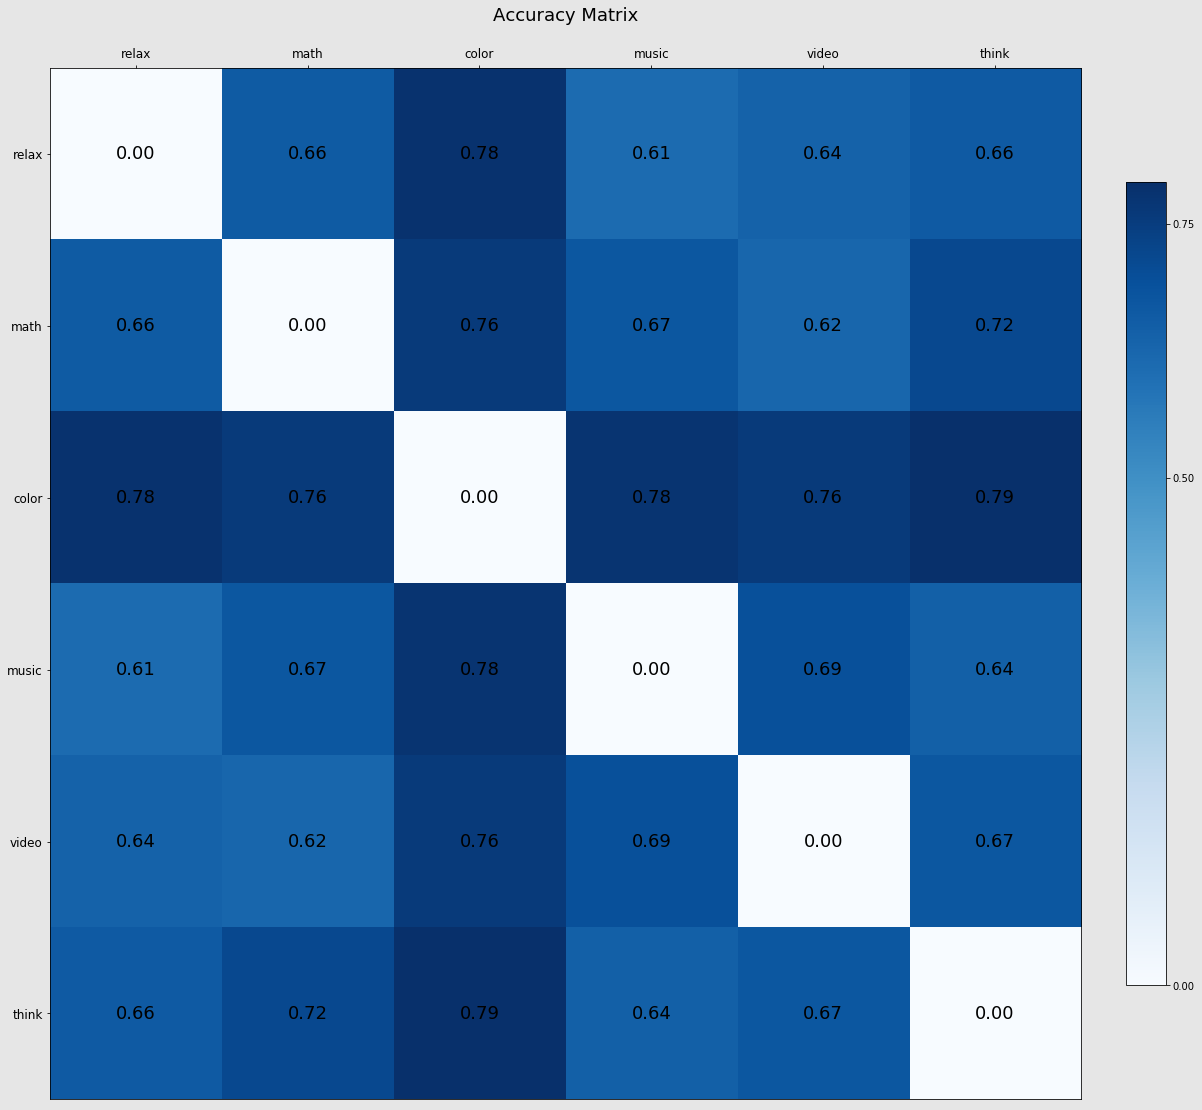

In [49]:
pd_mean = pd.DataFrame(pd_mean_list)
fig, ax = plt.subplots(figsize = [20,20], facecolor=[0.9,0.9,0.9])
cax = plt.imshow(pd_mean, cmap='Blues',  interpolation='None')
#plt.colorbar(im)
# show the data in the small square，notice the sequence of i, j.
for i in range(0,6):
    for j in range(0,6):
        c = pd_mean.iloc[j,i]
        show_text = "{0:.2f}".format(c)
        ax.text(i, j, show_text, va='center', ha='center', fontsize = 18)
labels= ['relax', 'math', 'color', 'music', 'video', 'think']
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xticks(range(6))
ax.set_yticks(range(6))
ax.set_xticklabels(labels,fontsize=12)
ax.set_yticklabels(labels,fontsize=12)
plt.title('Accuracy Matrix', y= 1.04, fontsize = 18)
cbar = fig.colorbar(cax, ticks=[0, 0.5, 0.75], fraction=0.036, pad=0.04)
cbar.ax.set_xticklabels(['0', '0.5', '0.75'])  # horizontal colorbar
plt.show()

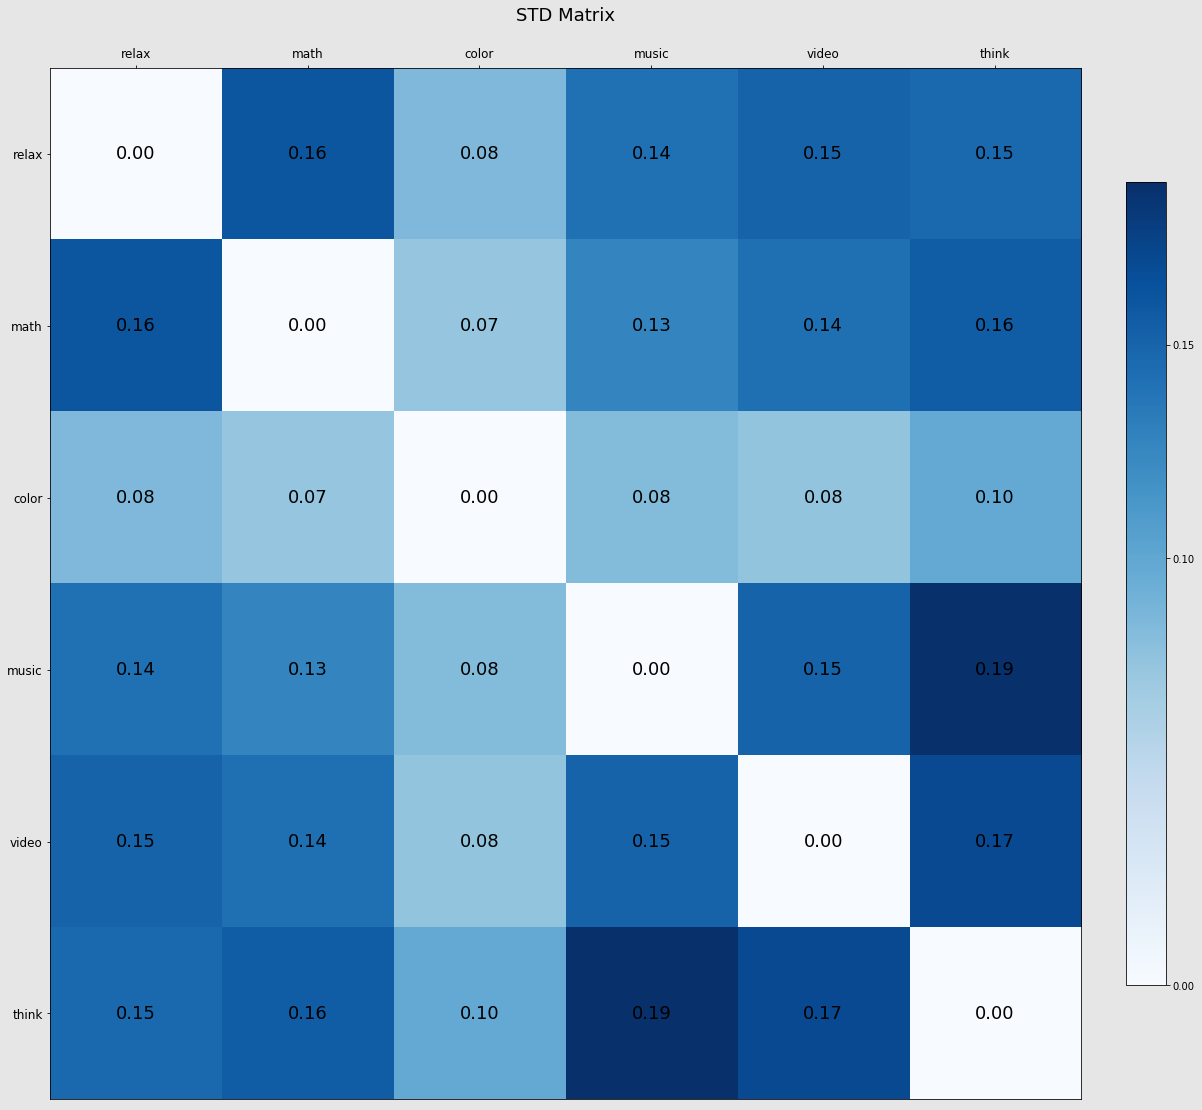

In [50]:
pd_std = pd.DataFrame(pd_std_list)
fig, ax = plt.subplots(figsize = [20,20], facecolor=[0.9,0.9,0.9])
cax = plt.imshow(pd_std, cmap='Blues',  interpolation='None')
#plt.colorbar(im)
# show the data in the small square，notice the sequence of i, j.
for i in range(0,6):
    for j in range(0,6):
        c = pd_std.iloc[j,i]
        show_text = "{0:.2f}".format(c)
        ax.text(i, j, show_text, va='center', ha='center', fontsize = 18)
labels= ['relax', 'math', 'color', 'music', 'video', 'think']
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xticks(range(6))
ax.set_yticks(range(6))
ax.set_xticklabels(labels,fontsize=12)
ax.set_yticklabels(labels,fontsize=12)
plt.title('STD Matrix', y= 1.04, fontsize = 18)
cbar = fig.colorbar(cax, ticks=[0, 0.1, 0.15], fraction=0.036, pad=0.04)
cbar.ax.set_xticklabels(['0', '0.1', '0.15'])  # horizontal colorbar
plt.show()

# Extra credit

Discover something new, and describe (or show) it below.

In the second week's lecture, we discussed the device for the late-stage A.L.S. patient and we talked about that each patient will have his/her own imagination to perform the same tasks. For example, someone images bringing her right thumb and ring finger together while someone images lifting up her left thumb only. In other words, even handling the same task, different people would have unique patterns.   

Thus I am wondering if we can differentiate the users based on their brain waves while they perform same activity. 

I studied this question in the following steps:

1. differentiate 2 subjects using "relax"  
The result is not very good. We just get 75% accuracy. Perhaps the reason is that the brain wave of the different subject during "relax" is quite similar. Then I tried a "work" phase since it requires some mental activities.

2. differentiate 2 subjects using "math"  
The result is better than "relax". I continued to see if the result can keep high when we differentiate more than 2 subjects.

3. differentiate 3 subjects using "math"
Surprisingly, the result is even better than step 2. It reaches 90%.   
Since in the above steps, I just tried to differentiate subjects id==1, id==2 or id ==3, I would like to randomly pick 3 subjects from 30 users and get the mean results to see how this method works. 

4. differentiate 3 subjects (combinations) using "math" 
The result is still quite good. The average result is around 80%, STD error is 0.10.
However, this step costs a long period of time, around 5 hours since the number of combinations is over 8 thousand. Due to the time limit, I was not able to run this step on 4 subjects, 5 subjects to 30 subjects one by one, so I just tried to run on 30 subjects. 

5. differentiate 30 subjects using "math"
The result is decreased quite a lot, only around 42%. Within the number of subjects grows, the difficulty also rises.

In general, when the number of subjects is small, the method is still feasible. However, based on the current result, it is still not reasonable to conclude that it would not work with a lot of subjects because I have only tried math on a different number of subjects (relax is only used for subject1 and subject2). To try other tasks and even the combination of multiple tasks to differentiate subjects could be a future work.   




### Identify user in relax (id = 1. id = 2)

In [69]:
# your code, or words, here
# All the readings during the "relax" task for id 1
relax1 = dataset[(dataset.label == 'relax') &
                (dataset.id == 1) ]
# All the readings during the "relax" task for id 2
relax2 = dataset[(dataset.label == 'relax') &
                (dataset.id == 2) ]

len(relax1), len(relax2)

(30, 30)

In [70]:
relax1_features = to_features(relax1)
relax2_features = to_features(relax2)
features = np.concatenate([relax1_features, relax2_features])
    
assert np.all( [ len(feat) == 256 for feat in features ] )

In [71]:
labels = np.array([ 0 for feature in relax1_features  ] \
                + [ 1 for feature in relax2_features ])

# list of labels should be the same 
# as the number of features
assert len(labels) == len(features)
# first label in the list should be 0
assert labels[1] == 0
# last label in the list should be 1
assert labels[-1] == 1

labels[:5], labels[-5:]

(array([0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1]))

In [72]:
assert features.shape[0] == labels.shape[0]

features.shape, labels.shape

((60, 256), (60,))

In [73]:
X = features
y = labels

In [74]:
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)

In [75]:
cvres.tail()

,test-auc-mean,test-auc-std,test-error@0.1-mean,test-error@0.1-std,train-auc-mean,train-auc-std,train-error@0.1-mean,train-error@0.1-std
95,0.904762,0.124984,0.347619,0.196685,1.0,0.0,0.070708,0.025871
96,0.904762,0.124984,0.347619,0.196685,1.0,0.0,0.070708,0.025871
97,0.904762,0.124984,0.347619,0.196685,1.0,0.0,0.070708,0.025871
98,0.904762,0.124984,0.347619,0.196685,1.0,0.0,0.070708,0.025871
99,0.904762,0.124984,0.347619,0.196685,1.0,0.0,0.070708,0.025871


In [76]:
clf.score(X_validate, y_validate)

0.75

In [77]:
clf = fresh_clf()
clf.fit(X_train, y_train)
clf.score(X_validate, y_validate)

0.75

### Identify user in math(id = 1. id = 2)

In [78]:
# your code, or words, here
# All the readings during the "relax" task for id 1
math1 = dataset[(dataset.label.str.match('math\d')) &
                (dataset.id == 1)]
# All the readings during the "relax" task for id 2
math2 = dataset[(dataset.label.str.match('math\d')) &
                (dataset.id == 2)]

len(math1), len(math2)

(30, 31)

In [79]:
math1_features = to_features(math1)
math2_features = to_features(math2)
features = np.concatenate([math1_features, math2_features])
    
assert np.all( [ len(feat) == 256 for feat in features ] )

In [80]:
labels = np.array([ 0 for feature in math1_features  ] \
                + [ 1 for feature in math2_features ])

# list of labels should be the same 
# as the number of features
assert len(labels) == len(features)
# first label in the list should be 0
assert labels[1] == 0
# last label in the list should be 1
assert labels[-1] == 1

labels[:5], labels[-5:]

(array([0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1]))

In [81]:
assert features.shape[0] == labels.shape[0]

features.shape, labels.shape

((61, 256), (61,))

In [82]:
X = features
y = labels

In [83]:
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)

In [84]:
cvres.tail()

,test-auc-mean,test-auc-std,test-error@0.1-mean,test-error@0.1-std,train-auc-mean,train-auc-std,train-error@0.1-mean,train-error@0.1-std
95,0.968254,0.077762,0.171429,0.126527,1.0,0.0,0.062425,0.028848
96,0.968254,0.077762,0.171429,0.126527,1.0,0.0,0.062425,0.028848
97,0.968254,0.077762,0.171429,0.126527,1.0,0.0,0.062425,0.028848
98,0.968254,0.077762,0.171429,0.126527,1.0,0.0,0.062425,0.028848
99,0.968254,0.077762,0.171429,0.126527,1.0,0.0,0.062425,0.028848


In [85]:
clf.score(X_validate, y_validate)

0.80952380952380953

In [86]:
clf = fresh_clf()
clf.fit(X_train, y_train)
clf.score(X_validate, y_validate)

0.80952380952380953

### Identify user in math(id = 1. id = 2. id =3)

In [87]:
def fresh_multi_clf () -> XGBClassifier:
    return XGBClassifier(
        # Don't worry about those parameters for now,
        # though feel free to look them up if you're interested.
        objective= 'multi:softprob',
        seed=27)

clf = fresh_clf()

In [88]:
def xgb_multi_cross_validate (
    X: np.array,
    y: np.array,
    nfold: int=7,
    num_class: int=3
) -> Tuple[XGBClassifier, pd.DataFrame]:
    # eval_metrics:
    # http://xgboost.readthedocs.io/en/latest//parameter.html
    metrics = ['merror']
#     metrics = [ 'auc' ]
    # we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
    # the intent here to to minimize FAR at the expense of FRR
    alg = fresh_multi_clf()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    param['num_class'] = num_class  # set the number of classes
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=100
                      )
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

In [89]:
# your code, or words, here
# All the readings during the "relax" task for id 1
math1 = dataset[(dataset.label.str.match('math\d')) &
                (dataset.id == 1)]
# All the readings during the "relax" task for id 2
math2 = dataset[(dataset.label.str.match('math\d')) &
                (dataset.id == 2)]
math3 = dataset[(dataset.label.str.match('math\d')) &
                (dataset.id == 3)]


len(math1), len(math2), len(math3)

(30, 31, 32)

In [90]:
math1_features = to_features(math1)
math2_features = to_features(math2)
math3_features = to_features(math3)
features = np.concatenate([math1_features, math2_features, math3_features])
#features = np.concatenate([math1_features, math2_features])
    
assert np.all( [ len(feat) == 256 for feat in features ] )

In [91]:
labels = np.array([ 0 for feature in math1_features  ] \
                + [ 1 for feature in math2_features  ] \
                + [ 2 for feature in math3_features  ])

# list of labels should be the same 
# as the number of features
assert len(labels) == len(features)
# first label in the list should be 0
assert labels[1] == 0
# last label in the list should be 1
assert labels[-1] == 2

labels[:5], labels[-5:]

(array([0, 0, 0, 0, 0]), array([2, 2, 2, 2, 2]))

In [92]:
assert features.shape[0] == labels.shape[0]

features.shape, labels.shape

((93, 256), (93,))

In [93]:
X = features
y = labels

In [94]:
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_multi_cross_validate(X_train, y_train)

In [95]:
cvres.tail()

,test-merror-mean,test-merror-std,train-merror-mean,train-merror-std
95,0.144841,0.128555,0.0,0.0
96,0.144841,0.128555,0.0,0.0
97,0.144841,0.128555,0.0,0.0
98,0.144841,0.128555,0.0,0.0
99,0.144841,0.128555,0.0,0.0


In [96]:
clf.score(X_validate, y_validate)

0.90322580645161288

### Identify 3 users in math

In [100]:
subject_list = list(range(1,31))

In [102]:
subject_combination = list(combinations(subject_list, 3))

In [104]:
dataset_dict = {}
dataset_dict[0] = dataset[(dataset.label == 'relax')]
dataset_dict[1] = dataset[(dataset.label.str.match('math\d'))]
dataset_dict[2] = dataset[(dataset.label.str.match('colorRound\d.*')) ]
dataset_dict[3] = dataset[(dataset.label == 'music')]
dataset_dict[4] = dataset[(dataset.label.str.match('video-ver\d')) ]
dataset_dict[5] = dataset[(dataset.label.str.match('thinkOfItems-ver\d'))]

In [111]:
temp_list = []
for item in subject_combination:
    print(item)
    dataset0 = dataset_dict[0][dataset_dict[0].id == item[0]]
    dataset1 = dataset_dict[0][dataset_dict[0].id == item[1]]
    dataset2 = dataset_dict[0][dataset_dict[0].id == item[2]]
    features0 = to_features(dataset0)
    features1 = to_features(dataset1)
    features2 = to_features(dataset2)
    features = np.concatenate([features0, features1, features2])
    labels = np.array([ 0 for feature in features0  ] \
                + [ 1 for feature in features1  ] \
                + [ 2 for feature in features2  ])
    assert features.shape[0] == labels.shape[0]
    X = features
    y = labels
    X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
                                                X, y, 
                                                test_size=0.33, 
                                                random_state=42)

    clf, cvres = xgb_multi_cross_validate(X_train, y_train)
    temp_list.append(clf.score(X_validate, y_validate))

(1, 2, 3)
(1, 2, 4)
(1, 2, 5)
(1, 2, 6)
(1, 2, 7)
(1, 2, 8)
(1, 2, 9)
(1, 2, 10)
(1, 2, 11)
(1, 2, 12)
(1, 2, 13)
(1, 2, 14)
(1, 2, 15)
(1, 2, 16)
(1, 2, 17)
(1, 2, 18)
(1, 2, 19)
(1, 2, 20)
(1, 2, 21)
(1, 2, 22)
(1, 2, 23)
(1, 2, 24)
(1, 2, 25)
(1, 2, 26)
(1, 2, 27)
(1, 2, 28)
(1, 2, 29)
(1, 2, 30)
(1, 3, 4)
(1, 3, 5)
(1, 3, 6)
(1, 3, 7)
(1, 3, 8)
(1, 3, 9)
(1, 3, 10)
(1, 3, 11)
(1, 3, 12)
(1, 3, 13)
(1, 3, 14)
(1, 3, 15)
(1, 3, 16)
(1, 3, 17)
(1, 3, 18)
(1, 3, 19)
(1, 3, 20)
(1, 3, 21)
(1, 3, 22)
(1, 3, 23)
(1, 3, 24)
(1, 3, 25)
(1, 3, 26)
(1, 3, 27)
(1, 3, 28)
(1, 3, 29)
(1, 3, 30)
(1, 4, 5)
(1, 4, 6)
(1, 4, 7)
(1, 4, 8)
(1, 4, 9)
(1, 4, 10)
(1, 4, 11)
(1, 4, 12)
(1, 4, 13)
(1, 4, 14)
(1, 4, 15)
(1, 4, 16)
(1, 4, 17)
(1, 4, 18)
(1, 4, 19)
(1, 4, 20)
(1, 4, 21)
(1, 4, 22)
(1, 4, 23)
(1, 4, 24)
(1, 4, 25)
(1, 4, 26)
(1, 4, 27)
(1, 4, 28)
(1, 4, 29)
(1, 4, 30)
(1, 5, 6)
(1, 5, 7)
(1, 5, 8)
(1, 5, 9)
(1, 5, 10)
(1, 5, 11)
(1, 5, 12)
(1, 5, 13)
(1, 5, 14)
(1, 5, 15)
(1, 5, 16)
(1, 5, 17)

(2, 19, 20)
(2, 19, 21)
(2, 19, 22)
(2, 19, 23)
(2, 19, 24)
(2, 19, 25)
(2, 19, 26)
(2, 19, 27)
(2, 19, 28)
(2, 19, 29)
(2, 19, 30)
(2, 20, 21)
(2, 20, 22)
(2, 20, 23)
(2, 20, 24)
(2, 20, 25)
(2, 20, 26)
(2, 20, 27)
(2, 20, 28)
(2, 20, 29)
(2, 20, 30)
(2, 21, 22)
(2, 21, 23)
(2, 21, 24)
(2, 21, 25)
(2, 21, 26)
(2, 21, 27)
(2, 21, 28)
(2, 21, 29)
(2, 21, 30)
(2, 22, 23)
(2, 22, 24)
(2, 22, 25)
(2, 22, 26)
(2, 22, 27)
(2, 22, 28)
(2, 22, 29)
(2, 22, 30)
(2, 23, 24)
(2, 23, 25)
(2, 23, 26)
(2, 23, 27)
(2, 23, 28)
(2, 23, 29)
(2, 23, 30)
(2, 24, 25)
(2, 24, 26)
(2, 24, 27)
(2, 24, 28)
(2, 24, 29)
(2, 24, 30)
(2, 25, 26)
(2, 25, 27)
(2, 25, 28)
(2, 25, 29)
(2, 25, 30)
(2, 26, 27)
(2, 26, 28)
(2, 26, 29)
(2, 26, 30)
(2, 27, 28)
(2, 27, 29)
(2, 27, 30)
(2, 28, 29)
(2, 28, 30)
(2, 29, 30)
(3, 4, 5)
(3, 4, 6)
(3, 4, 7)
(3, 4, 8)
(3, 4, 9)
(3, 4, 10)
(3, 4, 11)
(3, 4, 12)
(3, 4, 13)
(3, 4, 14)
(3, 4, 15)
(3, 4, 16)
(3, 4, 17)
(3, 4, 18)
(3, 4, 19)
(3, 4, 20)
(3, 4, 21)
(3, 4, 22)
(3, 4, 23)
(3, 

(4, 22, 24)
(4, 22, 25)
(4, 22, 26)
(4, 22, 27)
(4, 22, 28)
(4, 22, 29)
(4, 22, 30)
(4, 23, 24)
(4, 23, 25)
(4, 23, 26)
(4, 23, 27)
(4, 23, 28)
(4, 23, 29)
(4, 23, 30)
(4, 24, 25)
(4, 24, 26)
(4, 24, 27)
(4, 24, 28)
(4, 24, 29)
(4, 24, 30)
(4, 25, 26)
(4, 25, 27)
(4, 25, 28)
(4, 25, 29)
(4, 25, 30)
(4, 26, 27)
(4, 26, 28)
(4, 26, 29)
(4, 26, 30)
(4, 27, 28)
(4, 27, 29)
(4, 27, 30)
(4, 28, 29)
(4, 28, 30)
(4, 29, 30)
(5, 6, 7)
(5, 6, 8)
(5, 6, 9)
(5, 6, 10)
(5, 6, 11)
(5, 6, 12)
(5, 6, 13)
(5, 6, 14)
(5, 6, 15)
(5, 6, 16)
(5, 6, 17)
(5, 6, 18)
(5, 6, 19)
(5, 6, 20)
(5, 6, 21)
(5, 6, 22)
(5, 6, 23)
(5, 6, 24)
(5, 6, 25)
(5, 6, 26)
(5, 6, 27)
(5, 6, 28)
(5, 6, 29)
(5, 6, 30)
(5, 7, 8)
(5, 7, 9)
(5, 7, 10)
(5, 7, 11)
(5, 7, 12)
(5, 7, 13)
(5, 7, 14)
(5, 7, 15)
(5, 7, 16)
(5, 7, 17)
(5, 7, 18)
(5, 7, 19)
(5, 7, 20)
(5, 7, 21)
(5, 7, 22)
(5, 7, 23)
(5, 7, 24)
(5, 7, 25)
(5, 7, 26)
(5, 7, 27)
(5, 7, 28)
(5, 7, 29)
(5, 7, 30)
(5, 8, 9)
(5, 8, 10)
(5, 8, 11)
(5, 8, 12)
(5, 8, 13)
(5, 8, 14)
(5,

(7, 12, 21)
(7, 12, 22)
(7, 12, 23)
(7, 12, 24)
(7, 12, 25)
(7, 12, 26)
(7, 12, 27)
(7, 12, 28)
(7, 12, 29)
(7, 12, 30)
(7, 13, 14)
(7, 13, 15)
(7, 13, 16)
(7, 13, 17)
(7, 13, 18)
(7, 13, 19)
(7, 13, 20)
(7, 13, 21)
(7, 13, 22)
(7, 13, 23)
(7, 13, 24)
(7, 13, 25)
(7, 13, 26)
(7, 13, 27)
(7, 13, 28)
(7, 13, 29)
(7, 13, 30)
(7, 14, 15)
(7, 14, 16)
(7, 14, 17)
(7, 14, 18)
(7, 14, 19)
(7, 14, 20)
(7, 14, 21)
(7, 14, 22)
(7, 14, 23)
(7, 14, 24)
(7, 14, 25)
(7, 14, 26)
(7, 14, 27)
(7, 14, 28)
(7, 14, 29)
(7, 14, 30)
(7, 15, 16)
(7, 15, 17)
(7, 15, 18)
(7, 15, 19)
(7, 15, 20)
(7, 15, 21)
(7, 15, 22)
(7, 15, 23)
(7, 15, 24)
(7, 15, 25)
(7, 15, 26)
(7, 15, 27)
(7, 15, 28)
(7, 15, 29)
(7, 15, 30)
(7, 16, 17)
(7, 16, 18)
(7, 16, 19)
(7, 16, 20)
(7, 16, 21)
(7, 16, 22)
(7, 16, 23)
(7, 16, 24)
(7, 16, 25)
(7, 16, 26)
(7, 16, 27)
(7, 16, 28)
(7, 16, 29)
(7, 16, 30)
(7, 17, 18)
(7, 17, 19)
(7, 17, 20)
(7, 17, 21)
(7, 17, 22)
(7, 17, 23)
(7, 17, 24)
(7, 17, 25)
(7, 17, 26)
(7, 17, 27)
(7, 17, 28)
(7, 

(10, 15, 21)
(10, 15, 22)
(10, 15, 23)
(10, 15, 24)
(10, 15, 25)
(10, 15, 26)
(10, 15, 27)
(10, 15, 28)
(10, 15, 29)
(10, 15, 30)
(10, 16, 17)
(10, 16, 18)
(10, 16, 19)
(10, 16, 20)
(10, 16, 21)
(10, 16, 22)
(10, 16, 23)
(10, 16, 24)
(10, 16, 25)
(10, 16, 26)
(10, 16, 27)
(10, 16, 28)
(10, 16, 29)
(10, 16, 30)
(10, 17, 18)
(10, 17, 19)
(10, 17, 20)
(10, 17, 21)
(10, 17, 22)
(10, 17, 23)
(10, 17, 24)
(10, 17, 25)
(10, 17, 26)
(10, 17, 27)
(10, 17, 28)
(10, 17, 29)
(10, 17, 30)
(10, 18, 19)
(10, 18, 20)
(10, 18, 21)
(10, 18, 22)
(10, 18, 23)
(10, 18, 24)
(10, 18, 25)
(10, 18, 26)
(10, 18, 27)
(10, 18, 28)
(10, 18, 29)
(10, 18, 30)
(10, 19, 20)
(10, 19, 21)
(10, 19, 22)
(10, 19, 23)
(10, 19, 24)
(10, 19, 25)
(10, 19, 26)
(10, 19, 27)
(10, 19, 28)
(10, 19, 29)
(10, 19, 30)
(10, 20, 21)
(10, 20, 22)
(10, 20, 23)
(10, 20, 24)
(10, 20, 25)
(10, 20, 26)
(10, 20, 27)
(10, 20, 28)
(10, 20, 29)
(10, 20, 30)
(10, 21, 22)
(10, 21, 23)
(10, 21, 24)
(10, 21, 25)
(10, 21, 26)
(10, 21, 27)
(10, 21, 28)

(14, 19, 22)
(14, 19, 23)
(14, 19, 24)
(14, 19, 25)
(14, 19, 26)
(14, 19, 27)
(14, 19, 28)
(14, 19, 29)
(14, 19, 30)
(14, 20, 21)
(14, 20, 22)
(14, 20, 23)
(14, 20, 24)
(14, 20, 25)
(14, 20, 26)
(14, 20, 27)
(14, 20, 28)
(14, 20, 29)
(14, 20, 30)
(14, 21, 22)
(14, 21, 23)
(14, 21, 24)
(14, 21, 25)
(14, 21, 26)
(14, 21, 27)
(14, 21, 28)
(14, 21, 29)
(14, 21, 30)
(14, 22, 23)
(14, 22, 24)
(14, 22, 25)
(14, 22, 26)
(14, 22, 27)
(14, 22, 28)
(14, 22, 29)
(14, 22, 30)
(14, 23, 24)
(14, 23, 25)
(14, 23, 26)
(14, 23, 27)
(14, 23, 28)
(14, 23, 29)
(14, 23, 30)
(14, 24, 25)
(14, 24, 26)
(14, 24, 27)
(14, 24, 28)
(14, 24, 29)
(14, 24, 30)
(14, 25, 26)
(14, 25, 27)
(14, 25, 28)
(14, 25, 29)
(14, 25, 30)
(14, 26, 27)
(14, 26, 28)
(14, 26, 29)
(14, 26, 30)
(14, 27, 28)
(14, 27, 29)
(14, 27, 30)
(14, 28, 29)
(14, 28, 30)
(14, 29, 30)
(15, 16, 17)
(15, 16, 18)
(15, 16, 19)
(15, 16, 20)
(15, 16, 21)
(15, 16, 22)
(15, 16, 23)
(15, 16, 24)
(15, 16, 25)
(15, 16, 26)
(15, 16, 27)
(15, 16, 28)
(15, 16, 29)

In [112]:
np.mean(temp_list)

0.80357180444608689

In [113]:
np.std(temp_list)

0.10284716849560838

### Identify 30 users in math

In [376]:
math = dataset[(dataset.label.str.match('math\d'))]

In [386]:
features = to_features(math)

In [387]:
labels = np.array(math.id)

In [388]:
assert features.shape[0] == labels.shape[0]

features.shape, labels.shape

((936, 256), (936,))

In [389]:
X = features
y = labels

In [391]:
X_train, X_validate, y_train, y_validate = sklearn.model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=4)

clf, cvres = xgb_multi_cross_validate(X_train, y_train, num_class=31)

In [392]:
clf.score(X_validate, y_validate)

0.41747572815533979